In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

for col in test.columns: test[col] = test[col].astype('float32')
for col in train.columns: train[col] = train[col].astype('float32')

def delete_same_value_col(df):
    return df.drop(df.columns[df.max() == df.min()], axis = 1)

train = delete_same_value_col(train)
test  = delete_same_value_col(test)

In [3]:
minute = (train.id % 144 + 1).astype(int)
hour = (train.id % 24 + 1).astype(int)

minute_count = 24 * 6
hour_count = 24

minute_sin = np.sin(np.pi * minute / minute_count) 
minute_cos = np.cos(np.pi * minute / minute_count)

hour_sin  = np.sin(np.pi * hour / hour_count)
hour_cos  = np.cos(np.pi * hour / hour_count)

train['minute'] = minute
train['hour'] = hour
train['minute_sin'] = minute_sin
train['minute_cos'] = minute_cos
train['hour_sin'] = hour_sin
train['hour_cos'] = hour_cos
train['time_dummy'] = train['minute'].apply(lambda x: 1 if x < 73 else 2).astype('object')
train = pd.get_dummies(train)
train = train.drop(['id'], axis = 1)

In [4]:
train['temp'] = train[['X00', 'X07', 'X28', 'X31', 'X32']].mean(axis = 1)
train['spot_pressure'] = train[['X01', 'X06', 'X22', 'X27', 'X29']].mean(axis = 1)
train['wind_speed'] = train[['X02', 'X03', 'X18', 'X24', 'X26']].mean(axis = 1)
train['water'] = train[['X04', 'X10', 'X21', 'X36', 'X39']].mean(axis = 1)
train['see_pressure'] = train[['X05', 'X08', 'X09', 'X23', 'X33']].mean(axis = 1)
train['solar'] = train[['X11', 'X34']].mean(axis = 1)
train['wetness'] = train[['X12', 'X20', 'X30', 'X37', 'X38']].mean(axis = 1)
train['wind_direction'] = train[['X13', 'X15', 'X17', 'X25', 'X35']].mean(axis = 1)

train1 = train.iloc[0:4320, :]
train2 = train.iloc[4320:, :]

In [5]:
train1['Y18'] = train1[['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08',
                        'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']].mean(axis = 1)
train1 = train1.drop(['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08',
                      'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17'], axis = 1)
train2 = train2.drop(['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08',
                      'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17'], axis = 1)

train = pd.concat([train1, train2])

In [6]:
skewed = train.apply(lambda x: skew(x))
skewed = skewed[skewed > 0.7].index
train[skewed] = np.log1p(train[skewed])

train_Y = train['Y18']
train_X = train.drop('Y18', axis = 1)

In [7]:
def new_metric(y_pred, dataset):
    y_true = dataset.get_label()

    diff = abs(y_true - y_pred)
    less_then_one = np.array([0 if x < 1 else 1 for x in diff])

    y_pred = less_then_one * y_pred
    y_true = less_then_one *y_true
    
    score= mean_squared_error(y_true, y_pred)
    
    return 'score', score, False

In [18]:
'''
%%time
xgb_param_grid = {'objective':['reg:linear'],
                  'learning_rate': [0.01, 0.1, 0.5],
                  'max_depth': [7, 8, 9],
                  'n_estimators' : [2000],
                  'colsample_bytree' : [0.3, 0.5, 0.7, 0.9],
                  'subsample' : [0.3, 0.5, 0.7, 0.9],
                  'min_child_weight' : [1, 3, 5, 7]}

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = xgb_param_grid, cv = 4)
xgb_grid.fit(train_X, train_Y, eval_metric = new_metric)
'''

"\n%%time\nxgb_param_grid = {'objective':['reg:linear'],\n                  'learning_rate': [0.01, 0.1, 0.5],\n                  'max_depth': [7, 8, 9],\n                  'n_estimators' : [2000],\n                  'colsample_bytree' : [0.3, 0.5, 0.7, 0.9],\n                  'subsample' : [0.3, 0.5, 0.7, 0.9],\n                  'min_child_weight' : [1, 3, 5, 7]}\n\nxgb_model = xgb.XGBRegressor()\nxgb_grid = GridSearchCV(estimator = xgb_model, param_grid = xgb_param_grid, cv = 4)\nxgb_grid.fit(train_X, train_Y, eval_metric = new_metric)\n"

In [19]:
%%time
xgb_param_grid = {'objective':['reg:linear'],
                  'learning_rate': [0.01],
                  'max_depth': [9],
                  'n_estimators' : [4000],
                  'colsample_bytree' : [0.5],
                  'subsample' : [0.5]}

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = xgb_param_grid, cv = 4)
xgb_grid.fit(train_X, train_Y, eval_metric = new_metric)

[12:38:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[12:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[12:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 3min 33s


In [20]:
print('XGB Best score: {}'.format(xgb_grid.best_score_))
print('Best parameter: {}'.format(xgb_grid.best_params_))

XGB Best score: 0.9593479838804673
Best parameter: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 4000, 'objective': 'reg:linear', 'subsample': 0.5}


In [8]:
tune_xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 9, min_child_weight = 1,
                                  n_estimators = 5000, objective = 'reg:linear', subsample = 0.5)

tune_xgb_model.fit(train_X, train_Y)

[12:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=5000, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, subsample=0.5, tree_method=None,
       validate_parameters=False, verbosity=None)

In [9]:
#test
minute = (test.id % 144 + 1).astype(int)
hour = (test.id % 24 + 1).astype(int)

minute_count = 24*6
hour_count = 24

minute_sin = np.sin(np.pi * minute / minute_count) 
minute_cos = np.cos(np.pi * minute / minute_count)

hour_sin  = np.sin(np.pi * hour / hour_count)
hour_cos  = np.cos(np.pi * hour / hour_count)

test['minute'] = minute
test['hour'] = hour
test['minute_sin'] = minute_sin
test['minute_cos'] = minute_cos
test['hour_sin'] = hour_sin
test['hour_cos'] = hour_cos
test['time_dummy'] = test['minute'].apply(lambda x: 1 if x < 73 else 2).astype('object')
test = pd.get_dummies(test)
test = test.drop(['id'], axis = 1)

In [10]:
test['temp'] = test[['X00', 'X07', 'X28', 'X31', 'X32']].mean(axis = 1)
test['spot_pressure'] = test[['X01', 'X06', 'X22', 'X27', 'X29']].mean(axis = 1)
test['wind_speed'] = test[['X02', 'X03', 'X18', 'X24', 'X26']].mean(axis = 1)
test['water'] = test[['X04', 'X10', 'X21', 'X36', 'X39']].mean(axis = 1)
test['see_pressure'] = test[['X05', 'X08', 'X09', 'X23', 'X33']].mean(axis = 1)
test['solar'] = test[['X11', 'X34']].mean(axis = 1)
test['wetness'] = test[['X12', 'X20', 'X30', 'X37', 'X38']].mean(axis = 1)
test['wind_direction'] = test[['X13', 'X15', 'X17', 'X25', 'X35']].mean(axis = 1)

test[skewed] = np.log1p(test[skewed])
submission['Y18'] = tune_xgb_model.predict(test)
submission.to_csv('submission8.csv', index = False)

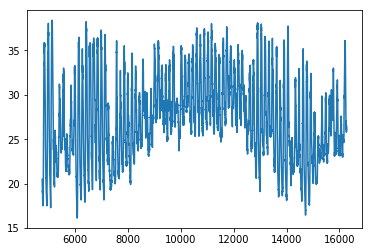

In [11]:
plt.plot(submission['id'], submission['Y18'])

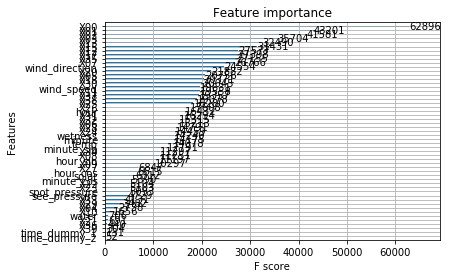

In [16]:
plot_importance(tune_xgb_model)